In [45]:
import numpy as np
import os
import pickle as pkl
from scipy.stats import pearsonr

from scipy.stats import pearsonr as pcc 

from keras.models import Model
from keras.layers import Dense, Input 
from keras.callbacks import EarlyStopping 
import os
import tensorflow as tf
import numpy as np

# Control randomness
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'
np.random.seed(42)
import random as rn
rn.seed(12345)
import matplotlib.pyplot as plt
import pandas as pd


## Preparing the data

In [60]:
import os
filenames = os.listdir("/content/drive/MyDrive/t4sne/train")
category = []

for i in filenames:
    if(i.split("_")[0]=="autistic"): category.append("autistic")
    else: category.append("non_autistic")

category

df = pd.DataFrame({"filename":filenames, "category": category})

def interaction_score(x):
  if x =="autistc": return np.random.randint(1, 50)/10
  else: return np.random.randint(51, 100)/10
df["interaction_score"] = df["category"].apply(interaction_score)
df

,filename,category,interaction_score
0,autistic_0262.jpg,autistic,9.4
1,autistic_0130.jpg,autistic,8.0
2,autistic_0220.jpg,autistic,7.9
3,autistic_0445.jpg,autistic,8.9
4,autistic_0716.jpg,autistic,9.1
...,...,...,...
2521,non_autistic_1131.jpg,non_autistic,9.6
2522,non_autistic_0718.jpg,non_autistic,7.0
2523,non_autistic_0381.jpg,non_autistic,9.6
2524,non_autistic_0423.jpg,non_autistic,9.1


## Classifying Autistic and Non-Autistic

In [61]:
from sklearn.model_selection import train_test_split

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)



In [62]:
# reset the index for trai and validation
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [63]:
batch_size=15
# FAST_RUN = False
IMAGE_SIZE = (128, 128)
IMAGE_CHANNELS = 3

In [75]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,  #df_name
    "/content/drive/MyDrive/t4sne/train/", #folder path
    x_col='filename', #column name of dataframe with images
    y_col='category', # column name of dataframe with classes
    target_size=IMAGE_SIZE, #provide target image size
    batch_size=batch_size # provide batch size
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/t4sne/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 2020 validated image filenames belonging to 2 classes.
Found 506 validated image filenames belonging to 2 classes.


In [78]:
model = keras.Sequential([
    # inputlayer
    keras.layers.Input(shape = (128, 128, 3)),
    # conv layer
    keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), strides=(1, 1), padding = "valid", activation = "relu"),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),

    keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), strides=(1, 1), padding = "valid", activation = "relu"),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),

    keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides=(1, 1), padding = "valid", activation = "relu"),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),

    # final layer
    keras.layers.Flatten(),
    keras.layers.Dense(units = 64, activation = "relu"),
    # output layer
    keras.layers.Dense(units = 2, activation = "softmax") # use "linear activation function for regression"
])
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 14, 14, 64)      

In [81]:
# epochs=3 if FAST_RUN else 50

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])


history = model.fit_generator(
    train_generator, 
    epochs=30,
    validation_data=validation_generator
#     callbacks=callbacks
)

Epoch 1/30


<ipython-input-81-4cecd6faa123>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


135/135 [==============================] - 42s 306ms/step - loss: 0.6903 - accuracy: 0.5292 - val_loss: 0.6721 - val_accuracy: 0.5929
Epoch 2/30
135/135 [==============================] - 37s 274ms/step - loss: 0.6742 - accuracy: 0.6010 - val_loss: 0.6505 - val_accuracy: 0.6067
Epoch 3/30
135/135 [==============================] - 32s 240ms/step - loss: 0.6418 - accuracy: 0.6381 - val_loss: 0.5977 - val_accuracy: 0.6897
Epoch 4/30
135/135 [==============================] - 36s 269ms/step - loss: 0.6318 - accuracy: 0.6475 - val_loss: 0.6093 - val_accuracy: 0.6957
Epoch 5/30
135/135 [==============================] - 32s 240ms/step - loss: 0.5945 - accuracy: 0.6921 - val_loss: 0.6143 - val_accuracy: 0.6719
Epoch 6/30
135/135 [==============================] - 32s 239ms/step - loss: 0.5875 - accuracy: 0.7020 - val_loss: 0.6053 - val_accuracy: 0.6937
Epoch 7/30
135/135 [==============================] - 36s 266ms/step - loss: 0.5670 - accuracy: 0.7035 - val_loss: 0.5943 - val_accuracy: 0.7

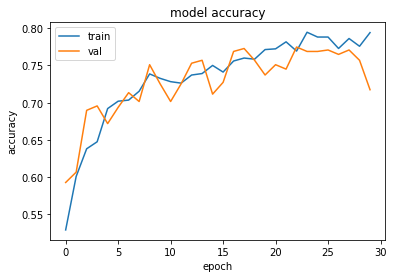

In [85]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



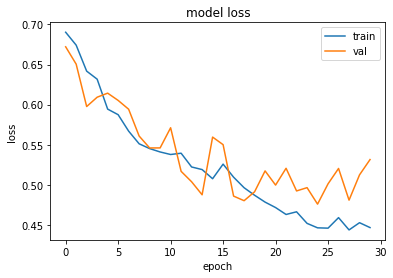

In [87]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()



## Predicting Interaction Score

In [82]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,  #df_name
    "/content/drive/MyDrive/t4sne/train/", #folder path
    x_col='filename', #column name of dataframe with images
    y_col='interaction_score', # column name of dataframe with classes
    class_mode = "raw",
    target_size=IMAGE_SIZE, #provide target image size
    batch_size=batch_size # provide batch size
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/t4sne/train/", 
    x_col='filename',
    y_col='interaction_score',
    class_mode = "raw",
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 2020 validated image filenames.
Found 506 validated image filenames.


In [72]:
import numpy as np
import pandas as pd 
import keras
import matplotlib.pyplot as plt
import random
import os



In [92]:
model = keras.Sequential([
    # inputlayer
    keras.layers.Input(shape = (128, 128, 3)),
    # conv layer
    keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), strides=(1, 1), padding = "valid", activation = "relu"),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),

    keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), strides=(1, 1), padding = "valid", activation = "relu"),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),

    keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides=(1, 1), padding = "valid", activation = "relu"),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),

    # final layer
    keras.layers.Flatten(),
    keras.layers.Dense(units = 64, activation = "relu"),
    # output layer
    keras.layers.Dense(units = 1, activation = "linear") # use "linear activation function for regression"
])
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 63, 63, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 14, 14, 64)      

In [93]:


class genNet(Model):
    def __init__(self, input_dim, trainable=[True,True,True,True,True], lsize0=500, lsize1=200, lsize2=100, lsize3=50, epochs=20, batch_size=128, **kwargs):
        self.epochs = epochs 
        self.batch_size = batch_size

        inp = Input(shape=(input_dim,))
        l1 = Dense(lsize0, activation='relu', trainable=trainable[0])(inp)
        l2 = Dense(lsize1, activation='relu', trainable=trainable[1])(l1)
        l3 = Dense(lsize2, activation='relu', trainable=trainable[2])(l2)
        l4 = Dense(lsize3, activation='relu', trainable=trainable[3])(l3)
        l5 = Dense(1, activation='linear', trainable=trainable[4])(l4)        

        super(genNet, self).__init__(inputs=[inp], outputs=[l5]) 

    def train_model(self, x_train, y_train, x_val, y_val, dtype):
        self.compile(optimizer='adadelta', loss='mean_squared_error', metrics=['mae'])
        stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, mode='auto')
        self.fit(x_train, y_train, epochs=self.epochs, batch_size=self.batch_size, verbose=1, callbacks=[stopper], validation_data=(x_val,y_val))
        self.save_weights('Weights/{}_weights.h5'.format(dtype)) 

    def make_report(self, report_name, id_test, x_test, y_test, country_test, frame_test):
        if not os.path.exists('Reports/' + report_name):
            os.mkdir('Reports/' + report_name)
        results = self.predict(x_test)

        # Generate detailied evaluation report
        header = 'Country,Child,Frame'
        for output_layer in self.get_config()['output_layers']:
            header += ',{}_Actual'.format(output_layer[0])
        for output_layer in self.get_config()['output_layers']:
            header += ',{}_Prediction'.format(output_layer[0]) 
        header += '\n'

        with open('Reports/{}/evaluation_report.txt'.format(report_name), 'a') as f:
            if os.stat('Reports/{}/evaluation_report.txt'.format(report_name)).st_size == 0:
                f.write(header)
            for row in range(len(results)):
                entry = ','.join([str(i) for i in country_test[row]]) + ','
                entry += ','.join([str(i) for i in id_test[row]]) + ','
                entry += ','.join([str(i) for i in frame_test[row]]) + ','
                entry += ','.join([str(i) for i in y_test[row]]) + ','
                entry += ','.join([str(i) for i in results[row]]) + '\n'
                f.write(entry)

        cultures = np.unique(country_test)
        for c in cultures:
            culture_rows = np.where(country_test == c)[0] # get row numbers for culture c 
            culture_ids = id_test[culture_rows] # get ID rows for culture c 
            unique_ids = np.unique(culture_ids) # get unique IDs for culture c 

            for u in unique_ids: 
                all_id_rows = np.where(id_test == u)[0]
                id_rows = np.intersect1d(all_id_rows, culture_rows) # get ID rows for child u 

                id_icc = icc(results[id_rows], y_test[id_rows])[0] # compute ICC for child u 
                id_pcc = pcc(results[id_rows], y_test[id_rows])[0][0] # compute PCC for child u 
                id_ccc = ccc(results[id_rows], y_test[id_rows]) # compute CCC for child u 
                id_mae = mae(results[id_rows], y_test[id_rows]) # compute MAE for child u 

                icc_entry = '{},{},{}\n'.format(c, u, id_icc)
                pcc_entry = '{},{},{}\n'.format(c, u, id_pcc)
                ccc_entry = '{},{},{}\n'.format(c, u, id_ccc)
                mae_entry = '{},{},{}\n'.format(c, u, id_mae)
                
                with open('Reports/{}/icc_report.txt'.format(report_name), 'a') as f:
                    f.write(icc_entry)

                with open('Reports/{}/pcc_report.txt'.format(report_name), 'a') as f:
                    f.write(pcc_entry)

                with open('Reports/{}/ccc_report.txt'.format(report_name), 'a') as f:
                    f.write(ccc_entry)

                with open('Reports/{}/mae_report.txt'.format(report_name), 'a') as f:
                    f.write(mae_entry)

        return results 

if __name__ == '__main__':
    pass

In [94]:
# epochs=3 if FAST_RUN else 50

model.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["mse"])


history = model.fit_generator(
    train_generator, 
    epochs=10,
    validation_data=validation_generator
#     callbacks=callbacks
)

Epoch 1/10


<ipython-input-94-169f39a71259>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


135/135 [==============================] - 36s 259ms/step - loss: 3.5177 - mse: 3.5177 - val_loss: 2.4549 - val_mse: 2.4549
Epoch 2/10
135/135 [==============================] - 34s 254ms/step - loss: 2.5385 - mse: 2.5385 - val_loss: 2.2909 - val_mse: 2.2909
Epoch 3/10
135/135 [==============================] - 33s 247ms/step - loss: 2.3505 - mse: 2.3505 - val_loss: 2.1083 - val_mse: 2.1083
Epoch 4/10
135/135 [==============================] - 35s 257ms/step - loss: 2.1061 - mse: 2.1061 - val_loss: 2.1218 - val_mse: 2.1218
Epoch 5/10
135/135 [==============================] - 37s 276ms/step - loss: 2.1223 - mse: 2.1223 - val_loss: 2.1610 - val_mse: 2.1610
Epoch 6/10
135/135 [==============================] - 33s 244ms/step - loss: 2.0833 - mse: 2.0833 - val_loss: 2.2760 - val_mse: 2.2760
Epoch 7/10
135/135 [==============================] - 34s 254ms/step - loss: 2.0688 - mse: 2.0688 - val_loss: 2.1710 - val_mse: 2.1710
Epoch 8/10
135/135 [==============================] - 36s 267ms/st

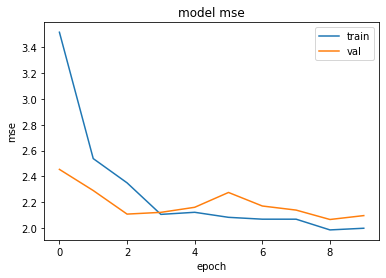

In [97]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()



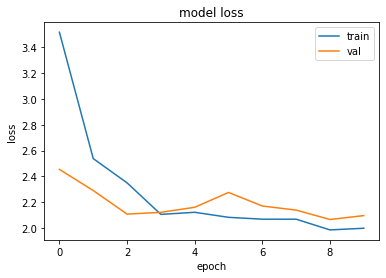

In [96]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

